In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from typing import List, Tuple
from adabmDCA.utils import resample_sequences

import torch
from aiDCA.binary import aiRBMbin
from aiDCA.dataset import DatasetBin

### Plot the results

In [2]:
fname_data = "/home/lorenzo/Documents/data/Test/MNIST/MNIST_train.dat"
fname_ann = "/home/lorenzo/Documents/data/Test/MNIST/MNIST_train_ann.csv"
fname_chains = "/home/lorenzo/Documents/FeF_temp/models/MNIST/prova_chains.fasta"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

In [4]:
rbm = aiRBMbin()
dataset = DatasetBin(
    path_data=fname_data,
    path_labels=fname_ann,
    device=device,
)

data = dataset.data
weights = dataset.weights
labels_data = dataset.to_label(dataset.labels_one_hot)

chains_all = rbm.load_chains(filename=fname_chains, device=device, dtype=dtype)
chains = chains_all["visible"]
labels_chains = dataset.to_label(chains_all["label"])

Dataset imported: M = 50000, L = 784, M_eff = 50000.


In [16]:
rbm.load(
    filename="/home/lorenzo/Documents/FeF_temp/models/MNIST/prova_params.h5",
    device=device,
    dtype=dtype,
)

mh = rbm.sample_hiddens(**chains_all)["hidden_mag"]
ml = rbm.sample_labels(mh)["label_mag"]
mv = rbm.sample_visibles(mh)["visible_mag"]
labels_chains = dataset.to_label(ml)

In [18]:
# project data and chains
_, _, Vt = torch.linalg.svd(data - data.mean(0), full_matrices=False)
data_proj = data @ Vt.T / data.shape[1]**0.5
#chains_proj = chains @ Vt.T / chains.shape[1]**0.5
chains_proj = mv @ Vt.T / chains.shape[1]**0.5
data_proj = data_proj.cpu().numpy()
chains_proj = chains_proj.cpu().numpy()

In [19]:
# Define the colors
unique_labels = np.unique(labels_data)
cmap = plt.get_cmap("tab10", len(unique_labels))
label_to_color = {label: cmap(i) for i, label in enumerate(unique_labels)}

In [20]:
def plot_hist(ax, data1, data2, color, dim, orientation='vertical'):    
    ax.hist(data1[:, dim], bins=40, color='black', histtype='step', zorder=0, density=True, orientation=orientation, lw=1)
    ax.hist(data2[:, dim], bins=40, color=color, histtype='step', zorder=1, density=True, orientation=orientation, lw=1.5)
    ax.axis('off')
    
def plot_PCA(
    fig: plt.figure,
    data1: np.array,
    labels1: np.ndarray,
    data2: np.array,
    labels2: np.ndarray,
    label_to_idx: dict,
    label_to_color: dict,
    dim1: int,
    dim2: int,
    title: str
):
    gs = GridSpec(4, 4)

    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_x = fig.add_subplot(gs[0, 0:3])
    ax_hist_y = fig.add_subplot(gs[1:4, 3])
    
    unique_labels = np.unique(labels1)
    for label in unique_labels:
        mask = labels1 == label
        ax_scatter.scatter(data1[mask, dim1], data1[mask, dim2], color=label_to_color[label], s=50, zorder=0, alpha=0.3)
    
    for label in unique_labels:
        mask = labels2 == label
        ax_scatter.scatter(data2[mask, dim1], data2[mask, dim2], color=label_to_color[label], s=20, zorder=2, edgecolor='black', marker='o', alpha=1, linewidth=0.4)
        
    plot_hist(ax_hist_x, data1, data2, 'red', dim1)
    plot_hist(ax_hist_y, data1, data2, 'red', dim2, orientation='horizontal')
    
    ax_scatter.set_xlabel(f"PC {dim1 + 1}")
    ax_scatter.set_ylabel(f"PC {dim2 + 1}")
    
    fig.suptitle(title)

    ax_hist_x.legend(fontsize=12, bbox_to_anchor=(1, 1));
    h, l = ax_scatter.get_legend_handles_labels()
    return fig


/tmp/ipykernel_1893200/29746361.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_hist_x.legend(fontsize=12, bbox_to_anchor=(1, 1));


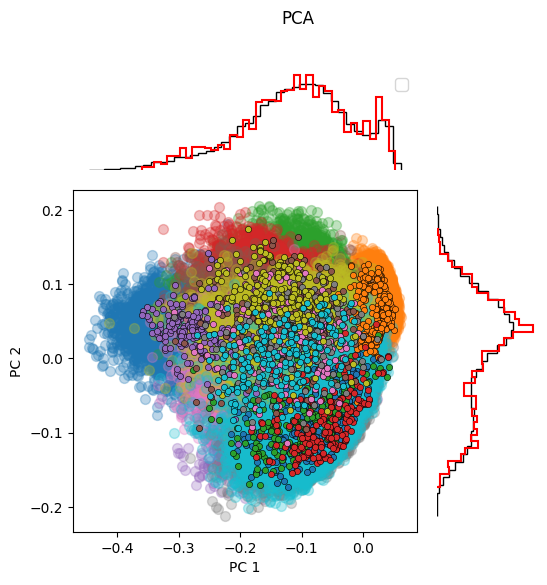

In [21]:
fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj,
    labels1=labels_data,
    data2=chains_proj,
    labels2=labels_chains,
    label_to_idx=dataset.label_to_idx,
    label_to_color=label_to_color,
    dim1=0,
    dim2=1,
    title="PCA"
)

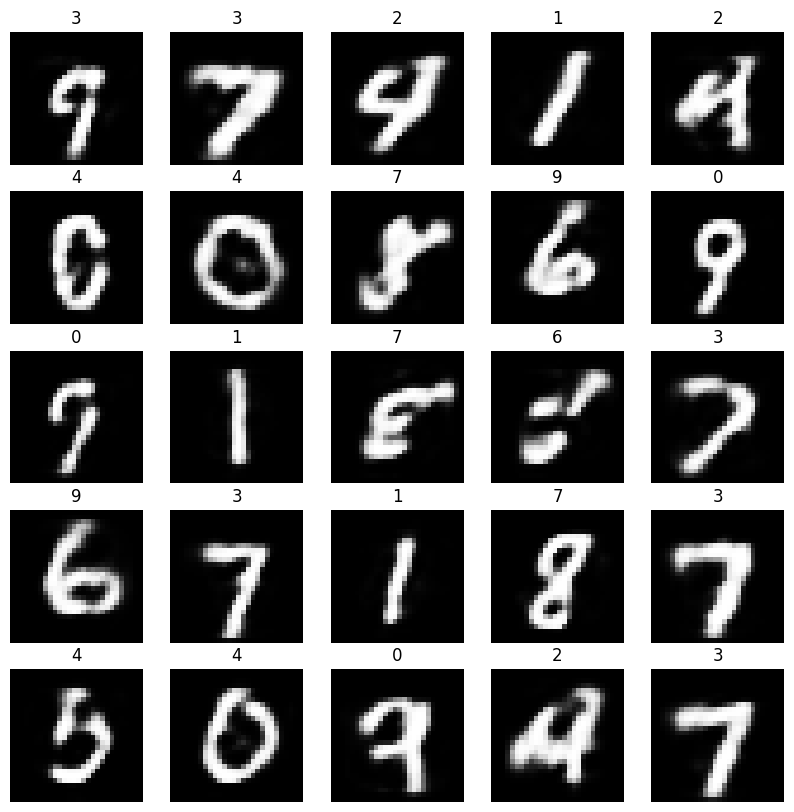

In [23]:
# Visualize the first 25 chains as mnist images with the corresponding labels
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(mv[i].cpu().numpy().reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(labels_chains[i])

<BarContainer object of 10 artists>

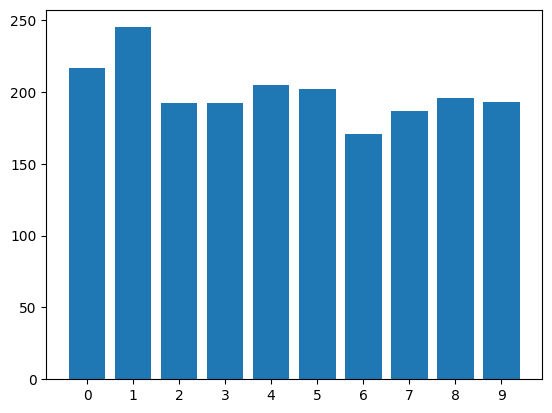

In [26]:
unique_labels, labels_count = np.unique(labels_chains, return_counts=True)
plt.bar(unique_labels, labels_count)

In [28]:
labels_oh = torch.nn.functional.one_hot(torch.tensor(labels_data.astype(int)), num_classes=10).to(device=device, dtype=dtype)
new_data = torch.hstack((data, labels_oh.float()))

In [32]:
_, _, Vt = torch.linalg.svd(new_data - new_data.mean(0), full_matrices=False)
new_data_proj = new_data @ Vt.T / new_data.shape[1]**0.5
new_data_proj = new_data_proj.cpu().numpy()

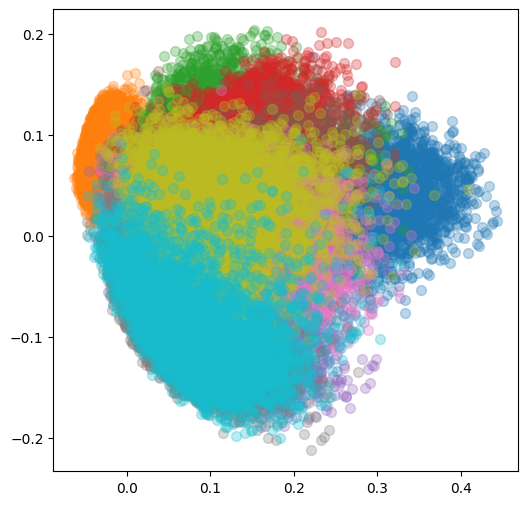

In [33]:
fig = plt.figure(figsize=(6, 6))
unique_labels = np.unique(labels_data)
for label in unique_labels:
    mask = labels_data == label
    plt.scatter(new_data_proj[mask, 0], new_data_proj[mask, 1], color=label_to_color[label], s=50, zorder=0, alpha=0.3)

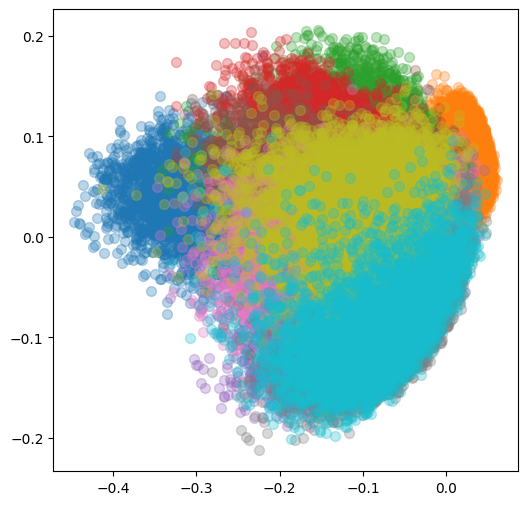

In [34]:
fig = plt.figure(figsize=(6, 6))
unique_labels = np.unique(labels_data)
for label in unique_labels:
    mask = labels_data == label
    plt.scatter(data_proj[mask, 0], data_proj[mask, 1], color=label_to_color[label], s=50, zorder=0, alpha=0.3)